# Artists and Songs table

In [4]:
from itertools import chain, combinations
import re
from pprint import pprint
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, IFrame

import networkx as nx
import plotly.graph_objects as go

sns.set_style('whitegrid')

In [5]:
df = pd.read_pickle('../data/data_collab.pkl')

In [3]:
def get_uniques(_df):
    songs = _df.sort_values('Weeks.on.chart', ascending=False).sort_values('Weekly.rank').groupby(['Artists', 'Name']).first().reset_index()
    artists = set(list(chain(*_df.Collaborators.tolist())))
    return songs, artists

In [4]:
df.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features,Collaborators
1,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,2019-04-05,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Jozzy, Atticus ross, Trent reznor, Billy ray c...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...",Billy Ray Cyrus,"[Lil Nas, Billy Ray Cyrus]"
2,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,2019-06-21,Pop,"Cashmere cat, Jack patterson, Charli xcx, Benn...",Senorita \nI love it when you call me senorita...,NaN,"[Shawn Mendes, Camila Cabello]"
3,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,2019-03-29,"Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","Billie eilish, Finneas","bad guy \nWhite shirt now red, my bloody nose\...",NaN,[Billie Eilish]
4,Khalid,Talk,4,3.0,20.0,2019-07-06,2019-02-07,"Synth-Pop,Pop","Howard lawrence, Guy lawrence, Khalid",Talk \nCan we just talk? Can we just talk?\nTa...,NaN,[Khalid]
5,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,2019-05-10,"Canada,UK,Dance,Dance-Pop,Pop","Ed sheeran, Justin bieber, Shellback, Max mart...",I Don't Care \nI'm at a party I don't wanna be...,NaN,"[Ed Sheeran, Justin Bieber]"


# Artists table

First, get an expanded list of artist - song table. Each of the collaborator gets a copy of the song.

In [1]:
# df = df[df['Weekly.rank'] <= 10]

In [6]:
expansion_idx = np.concatenate(df.apply(lambda row: len(row.Collaborators) * [row.name], axis=1).tolist())
expanded_artists = list(chain(*df.Collaborators.tolist()))

In [7]:
expanded_df = df.loc[expansion_idx, ['Name', 'Weekly.rank', 'Peak.position', 'Weeks.on.chart', 'Week', 'Date', 'Genre', 'Collaborators']].copy()
expanded_df['Artist'] = expanded_artists

In [8]:
expanded_df.head()

,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Collaborators,Artist
1,Old Town Road,1,1.0,7.0,2019-07-06,2019-04-05,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","[Lil Nas, Billy Ray Cyrus]",Lil Nas
1,Old Town Road,1,1.0,7.0,2019-07-06,2019-04-05,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","[Lil Nas, Billy Ray Cyrus]",Billy Ray Cyrus
2,Senorita,2,NaN,NaN,2019-07-06,2019-06-21,Pop,"[Shawn Mendes, Camila Cabello]",Shawn Mendes
2,Senorita,2,NaN,NaN,2019-07-06,2019-06-21,Pop,"[Shawn Mendes, Camila Cabello]",Camila Cabello
3,Bad Guy,3,2.0,13.0,2019-07-06,2019-03-29,"Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...",[Billie Eilish],Billie Eilish


Get properties of each artist, like the average rank on the chart across all songs or its top 5 songs, etc.

In [10]:
def get_artist_properties(g):
    d = {}
    weeksonchart_by_song = g[['Name', 'Weeks.on.chart']].groupby(['Name']).max()
    # d['date_min'] = g.Date.min()
    # d['date_max'] = g.Date.max()
    d['week_min'] = g.Week.min()
    d['week_max'] = g.Week.max()
    d['weeks_on_chart_total'] = g.shape[0]
    d['weeks_on_chart_longest'] = weeksonchart_by_song.max().iloc[0] # all nan?
    d['weeks_on_chart_mean'] = weeksonchart_by_song.mean().iloc[0] # all nan?
    d['rank_min'] = g['Weekly.rank'].min()
    d['rank_mean5'] = g[['Name', 'Weekly.rank']].groupby(['Name']).apply(lambda g: g['Weekly.rank'].sort_values().iloc[:5].mean()).sort_values().iloc[:5].mean()
    d['rank_mean'] = g[['Name', 'Weekly.rank']].groupby(['Name']).mean().mean().iloc[0]
    d['rank_median'] = g[['Name', 'Weekly.rank']].groupby(['Name']).median().median().iloc[0]
    d['rank_min_mean'] = g[['Name', 'Weekly.rank']].groupby(['Name']).min().mean().iloc[0]
    d['rank_min_mean5'] = g[['Name', 'Weekly.rank']].groupby(['Name']).min().sort_values('Weekly.rank').iloc[:5].mean().iloc[0]
    d['rank_min_median'] = g[['Name', 'Weekly.rank']].groupby(['Name']).min().median().iloc[0]
    d['num_songs'] = weeksonchart_by_song.shape[0]
    # d['songs'] = list(set(g['Name'].tolist()))
    return pd.Series(d)

Create $y$ coordinate ranges for artists

### Node positions

- `(min(week_min), max(week_max))`$\to (-1, 1)$ for $y$
  - Artist's $y$-coordinate moves from `week_min` to `week_max`
- $x$: take from spring layout?

$f(t_\text{min}) = -1$

$f(t_\text{max}) = 1$

$$f(t)=2\times \frac{t - t_\text{min}}{t_\text{max}-t_\text{min}} - 1$$

In [16]:
display(Markdown(f"Data range: {df.Week.min().date()} ~ {df.Week.max().date()}"))

Data range: 1999-07-12 ~ 2019-07-06

In [11]:
artist_prop = expanded_df.groupby('Artist').apply(get_artist_properties).reset_index()

tmin, tmax = artist_prop.week_min.min().timestamp(), artist_prop.week_max.max().timestamp()

def rescale_timestamp(t):
    return 2 * (t - tmin) / (tmax - tmin) - 1

artist_prop['y_min'] = artist_prop.week_min.apply(lambda x: rescale_timestamp(x.timestamp()))
artist_prop['y_max'] = artist_prop.week_max.apply(lambda x: rescale_timestamp(x.timestamp()))
artist_prop = artist_prop.rename(columns={'Artist': 'name'})

artist_prop.index.name = 'artist_id'

### Save as json

In [40]:
json.loads(artist_prop.head(2).to_json(orient='table'))

{'schema': {'fields': [{'name': 'artist_id', 'type': 'integer'},
   {'name': 'name', 'type': 'string'},
   {'name': 'week_min', 'type': 'datetime'},
   {'name': 'week_max', 'type': 'datetime'},
   {'name': 'weeks_on_chart_total', 'type': 'integer'},
   {'name': 'weeks_on_chart_longest', 'type': 'number'},
   {'name': 'weeks_on_chart_mean', 'type': 'number'},
   {'name': 'rank_min', 'type': 'integer'},
   {'name': 'rank_mean5', 'type': 'number'},
   {'name': 'rank_mean', 'type': 'number'},
   {'name': 'rank_median', 'type': 'number'},
   {'name': 'rank_min_mean', 'type': 'number'},
   {'name': 'rank_min_mean5', 'type': 'number'},
   {'name': 'rank_min_median', 'type': 'number'},
   {'name': 'num_songs', 'type': 'integer'},
   {'name': 'y_min', 'type': 'number'},
   {'name': 'y_max', 'type': 'number'}],
  'primaryKey': ['artist_id'],
  'pandas_version': '0.20.0'},
 'data': [{'artist_id': 0,
   'name': "'N Sync",
   'week_min': '1999-10-11T00:00:00.000Z',
   'week_max': '2001-01-09T00:00:

In [28]:
artist_prop.to_json('../data/artists_table.json', orient='table')

In [41]:
# artist_prop.to_json('../data/artists_top10_table.json', orient='table')

In [64]:
artist_prop.to_pickle('../data/artist_properties.pkl')

# Songs table

Songs will be the edges in our network of collaboration

Create a map from artist name to artist index.

In [42]:
artist2idx = {}
for i, a in enumerate(artist_prop['name']):
    artist2idx[a] = i

Get properties of the songs

In [31]:
def get_song_properties(g):
    d = {}
    d['rank_min'] = g['Weekly.rank'].min()
    d['rank_mean5'] = g['Weekly.rank'].sort_values().iloc[:5].mean()
    d['rank_mean'] = g['Weekly.rank'].mean()
    d['rank_median'] = g['Weekly.rank'].median()
    d['weeks_on_chart'] = g['Weeks.on.chart'].max()
    d['week_min'], d['week_max'] = g['Week'].min(), g['Week'].max()
    d['collaborators_id'] = [artist2idx[a] for a in g.Collaborators.iloc[0]]
    return pd.Series(d)

In [43]:
song_prop = df.groupby(
    ['Artists', 'Name']
).apply(get_song_properties).reset_index().rename(
    columns={'Name': 'name'}
).drop('Artists', axis=1)

song_prop.index.name = 'song_id'

In [35]:
song_prop.to_json('../data/songs_table.json', orient='table')

In [45]:
song_prop.to_json('../data/songs_top10_table.json', orient='table')

In [44]:
json.loads(song_prop.head(2).to_json(orient='table'))

{'schema': {'fields': [{'name': 'song_id', 'type': 'integer'},
   {'name': 'name', 'type': 'string'},
   {'name': 'rank_min', 'type': 'integer'},
   {'name': 'rank_mean5', 'type': 'number'},
   {'name': 'rank_mean', 'type': 'number'},
   {'name': 'rank_median', 'type': 'number'},
   {'name': 'weeks_on_chart', 'type': 'number'},
   {'name': 'week_min', 'type': 'datetime'},
   {'name': 'week_max', 'type': 'datetime'},
   {'name': 'collaborators_id', 'type': 'string'}],
  'primaryKey': ['song_id'],
  'pandas_version': '0.20.0'},
 'data': [{'song_id': 0,
   'name': 'Bye Bye Bye',
   'rank_min': 4,
   'rank_mean5': 4.6,
   'rank_mean': 5.75,
   'rank_median': 5.5,
   'weeks_on_chart': 17.0,
   'week_min': '2000-02-28T00:00:00.000Z',
   'week_max': '2000-05-16T00:00:00.000Z',
   'collaborators_id': [0]},
  {'song_id': 1,
   'name': "It's Gonna Be Me",
   'rank_min': 1,
   'rank_mean5': 2.6,
   'rank_mean': 5.1818181818,
   'rank_median': 5.0,
   'weeks_on_chart': 18.0,
   'week_min': '2000-0

# Histograms of Artist Properties

In [21]:
numeric_properties = artist_prop.select_dtypes(include=[int, float]).drop(columns=['y_min', 'y_max']).columns

## weeks on chart total

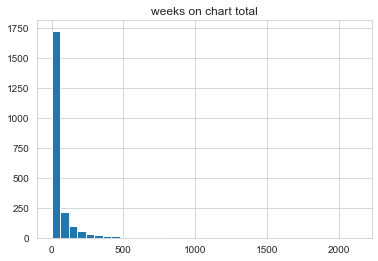

,name,weeks_on_chart_total
artist_id,,
580,Drake,2124
1173,Lil Wayne,1568
392,Chris Brown,1256
1641,Rihanna,1202
1449,Nicki Minaj,1184
1880,Taylor Swift,1019
1021,Kanye West,885
203,Beyonce,800
1055,Kenny Chesney,749


## weeks on chart longest

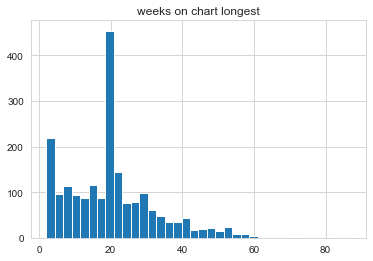

,name,weeks_on_chart_longest
artist_id,,
843,Imagine Dragons,87.0
39,AWOLNATION,79.0
900,Jason Mraz,76.0
1490,OneRepublic,68.0
51,Adele,65.0
337,Carrie Underwood,64.0
1938,The Lumineers,62.0
1153,Lifehouse,62.0
1120,Lady Antebellum,60.0


## weeks on chart mean

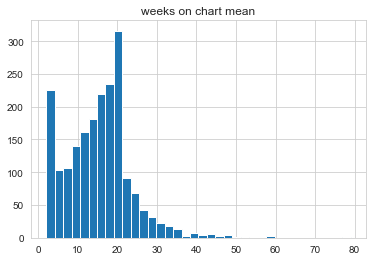

,name,weeks_on_chart_mean
artist_id,,
39,AWOLNATION,79.0
1087,Kimbra,59.0
766,Gotye,59.0
880,James Arthur,52.0
1756,Silento,51.0
2099,Wanz,49.0
185,Bastille,49.0
1479,Of Monsters And Men,48.0
1856,T.I. + Pharrell,48.0


## rank min

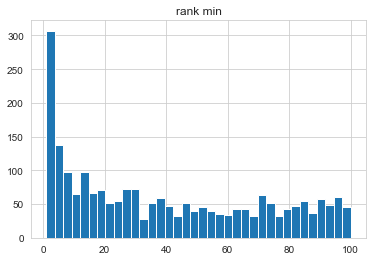

,name,rank_min
artist_id,,
2212,will.i.am,1
1818,Static Major,1
1203,Lonestar,1
163,B.o.B,1
1803,Soulja Slim,1
165,B2K,1
1205,Lorde,1
1802,Soulja Boy Tell'em,1
1218,Ludacris,1


## rank mean5

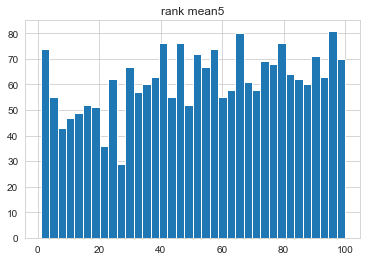

,name,rank_mean5
artist_id,,
1611,Ray Dalton,1.0
1087,Kimbra,1.0
580,Drake,1.0
1641,Rihanna,1.0
1236,MAGIC!,1.0
1110,Kyla,1.0
1856,T.I. + Pharrell,1.0
1948,The Product G&B,1.0
498,Daniel Powter,1.0


## rank mean

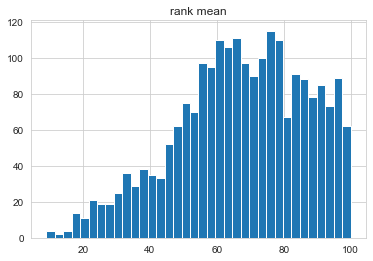

,name,rank_mean
artist_id,,
2071,Usher And Alicia Keys,9.000000
1791,Soko,9.000000
1948,The Product G&B,10.500000
1163,Lil Nas,11.411765
1110,Kyla,12.305556
2121,WizKid,12.305556
1632,"Ricardo ""RikRok"" Ducent",15.142857
473,DJ Frank E,15.960000
239,BlocBoy JB,16.120000


## rank median

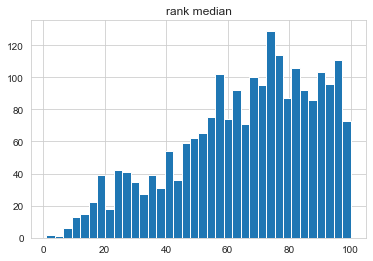

,name,rank_median
artist_id,,
1163,Lil Nas,1.0
1948,The Product G&B,2.5
2071,Usher And Alicia Keys,5.0
1632,"Ricardo ""RikRok"" Ducent",7.0
2121,WizKid,7.5
1110,Kyla,7.5
1791,Soko,9.0
239,BlocBoy JB,9.0
1389,Murda Beatz,9.0


## rank min mean

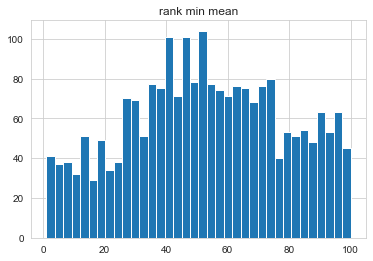

,name,rank_min_mean
artist_id,,
1611,Ray Dalton,1.0
455,Crazy Town,1.0
2121,WizKid,1.0
1236,MAGIC!,1.0
2099,Wanz,1.0
171,Baauer,1.0
2071,Usher And Alicia Keys,1.0
1099,Krayzie Bone,1.0
1948,The Product G&B,1.0


## rank min mean5

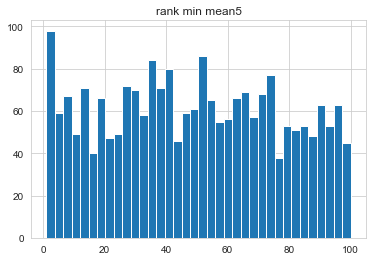

,name,rank_min_mean5
artist_id,,
1611,Ray Dalton,1.0
1278,Mariah Carey,1.0
171,Baauer,1.0
455,Crazy Town,1.0
2099,Wanz,1.0
2071,Usher And Alicia Keys,1.0
2070,Usher,1.0
203,Beyonce,1.0
2121,WizKid,1.0


## rank min median

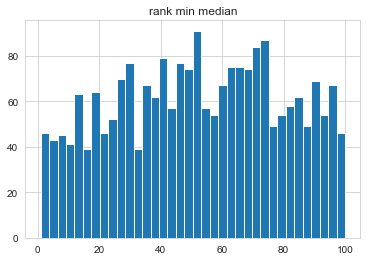

,name,rank_min_median
artist_id,,
1099,Krayzie Bone,1.0
997,Justin,1.0
2121,WizKid,1.0
1856,T.I. + Pharrell,1.0
2099,Wanz,1.0
1803,Soulja Slim,1.0
1110,Kyla,1.0
1611,Ray Dalton,1.0
1087,Kimbra,1.0


## num songs

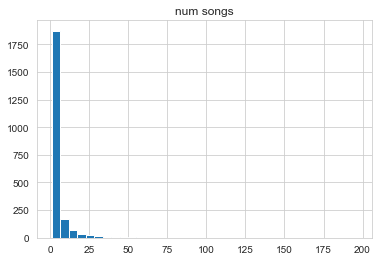

,name,num_songs
artist_id,,
754,Glee Cast,196
580,Drake,186
1173,Lil Wayne,139
1449,Nicki Minaj,93
392,Chris Brown,86
721,Future,83
1880,Taylor Swift,77
1021,Kanye West,76
629,Eminem,68


In [32]:
for col in numeric_properties:
    display(Markdown(f"## {col.replace('_', ' ')}"))
    plt.figure()
    artist_prop[col].hist(bins=36)
    plt.title(col.replace('_', ' '))
    plt.show()
    
    ascending = False
    if col.startswith('rank'):
        ascending = True
        
    display(artist_prop[['name', col]].sort_values(by=col, ascending=ascending).head(10))

In [34]:
artist_prop.loc[artist_prop['num_songs'].sort_values(ascending=False).index[:50]]

,name,week_min,week_max,weeks_on_chart_total,weeks_on_chart_longest,weeks_on_chart_mean,rank_min,rank_mean5,rank_mean,rank_median,rank_min_mean,rank_min_mean5,rank_min_median,num_songs,y_min,y_max
artist_id,,,,,,,,,,,,,,,,
754,Glee Cast,2009-06-04,2013-10-25,244,7.0,2.468750,4,22.80,64.197340,64.75,59.295918,8.2,61.0,196,-0.009453,0.430059
580,Drake,2009-05-21,2019-07-06,2124,36.0,13.188679,1,1.00,59.188800,64.25,42.145161,1.0,40.0,186,-0.013289,1.000000
1173,Lil Wayne,2002-07-02,2019-06-01,1568,40.0,15.895833,1,2.84,61.034964,62.50,45.762590,1.6,43.0,139,-0.702425,0.990410
1449,Nicki Minaj,2010-02-18,2019-07-06,1184,39.0,15.783784,2,3.76,56.753710,58.00,40.000000,3.0,38.0,93,0.061515,1.000000
392,Chris Brown,2005-08-24,2019-07-06,1256,38.0,16.460526,1,2.80,62.272977,64.25,47.023256,2.4,43.0,86,-0.387587,1.000000
721,Future,2011-04-14,2019-07-06,736,35.0,12.473684,5,13.72,72.283416,72.00,59.530120,11.2,62.0,83,0.176600,1.000000
1880,Taylor Swift,2006-09-20,2019-07-06,1019,50.0,18.181818,1,1.44,48.845065,45.00,29.000000,1.0,18.0,77,-0.280175,1.000000
1021,Kanye West,2003-11-25,2019-06-08,885,39.0,13.523077,1,1.72,58.719340,64.00,38.750000,1.2,34.5,76,-0.562406,0.992328
629,Eminem,2000-01-17,2019-06-15,667,30.0,13.326531,1,1.44,54.761508,56.50,33.132353,1.0,22.5,68,-0.948212,0.994246


In [82]:
np.corrcoef(artist_prop.weeks_on_chart, artist_prop.rank_median)

array([[ 1.       , -0.2783593],
       [-0.2783593,  1.       ]])

In [78]:
display(Markdown("### Most popular artists"))
display(artist_prop.sort_values('rank_median', ascending=True).head(10))

### Most popular artists

,date_min,date_max,week_min,week_max,rank_min,rank_mean5,rank_mean,rank_median,top_songs
Artist,,,,,,,,,
Lil Nas,2019-04-05,2019-04-05,2019-03-16,2019-07-06,1,1.0,11.411765,1.0,[Old Town Road]
The Product G&B,NaT,NaT,2000-02-07,2000-08-01,1,1.0,10.500000,2.5,[Maria Maria]
Static Major,2008-06-10,2018-06-29,2008-03-27,2018-07-28,1,1.0,18.709677,4.0,[Lollipop]
Usher And Alicia Keys,2004-10-05,2004-10-05,2004-09-08,2005-03-02,1,1.0,9.000000,5.0,[My Boo]
"Ricardo ""RikRok"" Ducent",2002-01-01,2002-01-01,2000-10-31,2001-04-17,1,1.6,15.142857,7.0,[It Wasn't Me]
Kyla,2016-04-05,2016-04-05,2016-04-23,2016-12-24,1,1.0,12.305556,7.5,[One Dance]
WizKid,2016-04-05,2016-04-05,2016-04-23,2016-12-24,1,1.0,12.305556,7.5,[One Dance]
Soko,2012-02-13,2012-02-13,2014-03-28,2014-03-28,9,9.0,9.000000,9.0,[We Might Be Dead By Tomorrow]
BlocBoy JB,2018-02-08,2018-02-08,2018-02-24,2018-08-11,5,5.4,16.120000,9.0,[Look Alive]


# Filter weekly top 10 only

In [27]:
top10 = df[df['Weekly.rank'] <= 10]

In [32]:
songs10, artists10 = get_uniques(top10)
artists10 = pd.Series(list(artists10), name='Artist').sort_values().reset_index(drop=True).to_frame()

In [33]:
artists10

,Artist
0,'N Sync
1,112
2,2 Chainz
3,21 Savage
4,3 Doors Down
...,...
574,benny blanco
575,fun.
576,matchbox twenty
577,twenty one pilots


In [34]:
songs10

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features,Collaborators
0,'N Sync,Bye Bye Bye,4,4.0,12.0,2000-04-11,2000-01-11,"Adult Contemporary,Dance-Pop,Teen Pop,Boy Band...","Andreas carlsson, Jake schulze, Kristian lundin","Bye Bye Bye \nHey, hey\nBye, bye, bye\nBye, by...",None,['N Sync]
1,'N Sync,It's Gonna Be Me,1,1.0,3.0,2000-07-25,2000-06-13,"Memes,Dance-Pop,Teen Pop,Boy Band,Pop","Rami, Andreas carlsson, Max martin","It's Gonna Be Me \nIt's gonna be me\nOh, yeah\...",None,['N Sync]
2,'N Sync,This I Promise You,5,5.0,10.0,2000-11-28,2000-11-25,"Ballad,Adult Contemporary,Neo Soul,Soul Pop,So...",Richard marx,This I Promise You \nWhen the visions around y...,None,['N Sync]
3,"'N Sync, Gloria Estefan",Music Of My Heart,2,2.0,7.0,1999-10-11,NaT,Pop,Diane warren,Music of My Heart \nYou'll never know\nWhat yo...,None,"['N Sync, Gloria Estefan]"
4,112,It's Over Now,6,6.0,15.0,2001-03-13,2001-01-30,R&;B,"Daron jones, Q parker, Grandmaster melle mel, ...","It's Over Now \nDaron\nWhat is this, numbers i...",None,[112]
...,...,...,...,...,...,...,...,...,...,...,...,...
1054,matchbox twenty,Unwell,5,5.0,21.0,2003-08-05,2003-04-03,"Adult Contemporary,Adult Alternative,Alternati...",Rob thomas,"Unwell \nAll day\nStaring at the ceilin', maki...",None,[matchbox twenty]
1055,twenty one pilots,Heathens,2,2.0,13.0,2016-10-01,2016-06-16,"Electronic Rock,Alternative Rock,Indie Rap,Rap...",Tyler joseph,"Heathens \nAll my friends are heathens, take i...",None,[twenty one pilots]
1056,twenty one pilots,Ride,5,5.0,24.0,2016-09-10,2015-05-11,"Soundtrack,Adult Alternative,Alternative Pop,I...",Tyler joseph,Ride \nI just wanna stay in the sun where I fi...,None,[twenty one pilots]
1057,twenty one pilots,Stressed Out,2,2.0,21.0,2016-02-26,2015-04-28,"Pop-Rock,Piano,Rap Rock,Adult Alternative,Alte...",Tyler joseph,Stressed Out \nI wish I found some better soun...,None,[twenty one pilots]


- add nodes using artist properties (`count=artist.num_songs`)
- song properties: peak position, weeks on chart (10위 기준), week.min(), week.max(), collaborators

In [66]:
top10.head(1)

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features,Collaborators
1,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,2019-04-05,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Jozzy, Atticus ross, Trent reznor, Billy ray c...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...",Billy Ray Cyrus,"[Lil Nas, Billy Ray Cyrus]"


In [83]:
a10_prop.iloc[0].week_min.timestamp()

939600000.0

In [81]:
a10_prop.columns

Index(['date_min', 'date_max', 'week_min', 'week_max', 'weeks_on_chart_total',
       'weeks_on_chart_longest', 'weeks_on_chart_mean', 'rank_min',
       'rank_mean5', 'rank_mean', 'rank_median', 'num_songs', 'top_songs'],
      dtype='object')

In [87]:
a10_prop.to_pickle('../data/a10_prop.pkl')
song_props.to_pickle('../data/s10_prop.pkl')

In [93]:
a10_prop

,date_min,date_max,week_min,week_max,weeks_on_chart_total,weeks_on_chart_longest,weeks_on_chart_mean,rank_min,rank_mean5,rank_mean,rank_median,num_songs,top_songs
Artist,,,,,,,,,,,,,
'N Sync,2000-01-11,2000-11-25,1999-10-11,2001-01-09,35,18.0,15.000000,1,2.0,5.714286,6.0,4,[It's Gonna Be Me]
112,2001-01-30,2001-04-03,2001-03-06,2001-07-31,10,17.0,16.500000,4,5.0,6.700000,6.5,2,[Peaches & Cream]
2 Chainz,2013-08-02,2013-08-02,2014-02-07,2014-06-06,18,23.0,23.000000,3,3.0,4.444444,4.0,1,[Talk Dirty]
21 Savage,2017-09-15,2017-09-15,2017-10-07,2018-05-12,24,33.0,33.000000,1,1.0,2.958333,2.0,1,[Rockstar]
3 Doors Down,2000-01-11,2002-11-12,2000-08-29,2004-02-10,44,39.0,31.000000,3,3.4,6.340909,6.0,3,[Kryptonite]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
benny blanco,2018-07-12,2018-07-12,2019-01-19,2019-02-23,2,31.0,31.000000,9,9.5,9.500000,9.5,1,[Eastside]
fun.,2011-09-20,2012-02-21,2012-02-23,2012-12-28,41,43.0,36.000000,1,1.0,4.000000,4.0,2,[We Are Young]
matchbox twenty,2000-05-23,2003-04-03,2000-07-04,2003-09-30,38,29.0,24.333333,1,2.2,6.815789,8.0,3,[Bent]


In [94]:
song_props

Artists                Name Weekly.rank  \
                                                            max   
0                       'N Sync         Bye Bye Bye           9   
1                       'N Sync    It's Gonna Be Me          10   
2                       'N Sync  This I Promise You          10   
3       'N Sync, Gloria Estefan   Music Of My Heart           6   
4                           112       It's Over Now           8   
...                         ...                 ...         ...   
1054            matchbox twenty              Unwell          10   
1055          twenty one pilots            Heathens           9   
1056          twenty one pilots                Ride          10   
1057          twenty one pilots        Stressed Out           9   
1058  will.i.am, Britney Spears      Scream & Shout           8   

     Weeks.on.chart       Week                           Collaborators  
                max        min        max                        first  
0              17.0 2000-02-28 2000-05-16                    ['N Sync]  
1              18.0 2000-06-20 2000-08-29                    ['N Sync]  
2              16.0 2000-10-31 2001-01-09                    ['N Sync]  
3               9.0 1999-10-11 1999-10-25    ['N Sync, Gloria Estefan]  
4              16.0 2001-03-06 2001-03-20                        [112]  
...             ...        ...        ...                          ...  
1054           29.0 2003-06-10 2003-09-30            [matchbox twenty]  
1055           25.0 2016-08-27 2016-12-24          [twenty one pilots]  
1056           27.0 2016-07-09 2016-10-01          [twenty one pilots]  
1057           28.0 2016-01-15 2016-04-16          [twenty one pilots]  
1058           16.0 2013-01-18 2013-03-29  [will.i.am, Britney Spears]  

[1059 rows x 7 columns]

In [84]:
G = nx.MultiGraph()
min_w, max_w = a10_prop.week_min.astype(int).min(), a10_prop.week_max.astype(int).max()
for i in range(a10_prop.shape[0]):
    row = a10_prop.iloc[i]
    G.add_node(i, artist=row.name, num_songs=row.num_songs, 
               week_min=(row.week_min.timestamp() - min_w) / (max_w - min_w), 
               week_max=(row.week_min.timestamp() - min_w) / (max_w - min_w),
              )

In [88]:
a10_prop.shape, song_props.shape

((579, 13), (1059, 7))

In [89]:
df.shape

(97225, 12)

In [90]:
expanded_df.shape

(13580, 8)

In [35]:
class GraphWrapper(object):
    def __init__(self, _df):
        songs = _df.sort_values('Weeks.on.chart', ascending=False).sort_values('Weekly.rank').groupby(['Artists', 'Name']).first().reset_index()
        artists = list(set(list(chain(*_df.Collaborators.tolist()))))
        songs['NumCollaborators'] = songs.Collaborators.apply(len)
        
        # artist maps
        artist2ind = {a: i for i, a in enumerate(sorted(artists))}

        G = nx.MultiGraph()
        counter = 0
        for row in songs.iterrows():
            collaborators = row.Collaborators
            for artist in collaborators:
                ind = artist2ind[artist]
                # Count number of appearances
                if ind not in G.nodes:
                    G.add_node(ind, artist=artist, count=1,)
                else:
                    #if 'artist' not in G.nodes[ind]:
                    #    G.nodes[ind]['artist'] = y
                    G.nodes[ind]['count'] += 1
            
            # add edges between each pair(2) of artists in the collaborators list of this song
            artist_indices = [artist2ind[artist] for artist in collaborators]
            for a, b in combinations(artist_indices, 2):
                # # Collaborations as weights
                # if G.has_edge(a, b):
                #     # we added this one before, just increase the weight by one
                #     G[a][b]['weight'] += 1
                # else:
                #     # new edge. add with weight=1
                #     G.add_edge(a, b, weight=1)
                # Collaboration as edges, allowing for parallel edges
                G.add_edge(a, b, song_name=row.Name)  # TODO: add other information

        self.songs = songs
        self.artists = artists
        self.artist2ind = artist2ind
        self.ind2artist = sorted(artists)
        self.graph = G
        self._connected_components = None
        self._cliques = None
            
    @property
    def connected_components(self):
        if self._connected_components is None:
            self._connected_components = list(nx.connected_components(self.graph))
        return self._connected_components
    
    @property
    def ccs(self):
        return self.connected_components
    
    @property
    def cliques(self):
        if self._cliques is None:
            self._cliques = list(nx.enumerate_all_cliques(self.graph))
        return self._cliques

In [36]:
net = GraphWrapper(top10)

In [38]:
pos = nx.spring_layout(net.graph, k=0.5, iterations=50)
for n, p in pos.items():
    net.graph.nodes[n]['pos'] = p

In [43]:
coords = pd.DataFrame(pos, index=['x', 'y']).T

In [45]:
coords.describe()

,x,y
count,5.790000e+02,5.790000e+02
mean,-3.349022e-08,-8.374665e-09
std,6.169271e-01,6.234404e-01
min,-9.991935e-01,-9.996602e-01
25%,-5.408265e-01,-5.334242e-01
50%,-2.451181e-03,-1.787573e-02
75%,5.590329e-01,5.454044e-01
max,9.973006e-01,1.000000e+00


In [47]:
top10.describe(datetime_is_numeric=True)

,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date
count,9656.000000,9495.000000,9495.000000,9656,9055
mean,5.484569,3.835387,13.961453,2009-08-25 03:27:53.239436800,2009-10-24 00:20:40.419657728
min,1.000000,1.000000,0.000000,1999-07-12 00:00:00,2000-01-11 00:00:00
25%,3.000000,1.000000,8.000000,2004-08-11 00:00:00,2005-01-15 00:00:00
50%,5.000000,3.000000,13.000000,2009-09-10 00:00:00,2010-01-01 00:00:00
75%,8.000000,6.000000,18.000000,2014-08-29 00:00:00,2014-07-08 00:00:00
max,10.000000,10.000000,59.000000,2019-07-06 00:00:00,2019-06-21 00:00:00
std,2.874407,2.753203,7.866954,NaN,NaN


In [80]:
expansion_idx = np.concatenate(top10.apply(lambda row: len(row.Collaborators) * [row.name], axis=1).tolist())
expanded_artists = list(chain(*top10.Collaborators.tolist()))

expanded_df = top10.loc[expansion_idx, ['Name', 'Weekly.rank', 'Peak.position', 'Weeks.on.chart', 'Week', 'Date', 'Genre']].copy()
expanded_df['Artist'] = expanded_artists

a10_prop = expanded_df.groupby('Artist').apply(get_artist_properties)

In [53]:
a10_prop.head()

,date_min,date_max,week_min,week_max,weeks_on_chart_total,weeks_on_chart_longest,weeks_on_chart_mean,rank_min,rank_mean5,rank_mean,rank_median,top_songs
Artist,,,,,,,,,,,,
'N Sync,2000-01-11,2000-11-25,1999-10-11,2001-01-09,35,18.0,15.0,1,2.0,5.714286,6.0,[It's Gonna Be Me]
112,2001-01-30,2001-04-03,2001-03-06,2001-07-31,10,17.0,16.5,4,5.0,6.700000,6.5,[Peaches & Cream]
2 Chainz,2013-08-02,2013-08-02,2014-02-07,2014-06-06,18,23.0,23.0,3,3.0,4.444444,4.0,[Talk Dirty]
21 Savage,2017-09-15,2017-09-15,2017-10-07,2018-05-12,24,33.0,33.0,1,1.0,2.958333,2.0,[Rockstar]
3 Doors Down,2000-01-11,2002-11-12,2000-08-29,2004-02-10,44,39.0,31.0,3,3.4,6.340909,6.0,[Kryptonite]


In [57]:
a10_prop.week_min.astype(int)

Artist
'N Sync               939600000000000000
112                   983836800000000000
2 Chainz             1391731200000000000
21 Savage            1507334400000000000
3 Doors Down          967507200000000000
                            ...         
benny blanco         1547856000000000000
fun.                 1329955200000000000
matchbox twenty       962668800000000000
twenty one pilots    1452816000000000000
will.i.am            1221696000000000000
Name: week_min, Length: 579, dtype: int64

In [ ]:
pos = nx.spring_layout(net.graph, k=0.5, iterations=50)
for n, p in pos.items():
    net.graph.nodes[n]['pos'] = p

In [ ]:
def make_network_figure(G):
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    for n, p in pos.items():
        G.nodes[n]['pos'] = p

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    num_occurrences = []  # use as node size
    artists = []  # use in node tooltip
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        num_occurrences.append(G.nodes[node]['count'] + 10)
        artists.append(G.nodes[node]['artist'])

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=num_occurrences,
            colorbar=dict(
                thickness=15,
                title='Number of collaborators',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    node_adjacencies = []  # Use as node color
    node_text = []  # Use in node tooltip

    for i, adjacencies in enumerate(G.adjacency()):
        n_collaborators = len(adjacencies[1])
        node_adjacencies.append(n_collaborators)
        node_text.append(
            '{}: appeared {} times, {} collaborators'.format(
                artists[i], num_occurrences[i], str(n_collaborators)
            )
        )

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
        title='Collaborating Artists in Billboard Weekly Hot 100 (1999-2019)',
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
    )
    return fig